## Import Libraries


In [12]:
# Base libraries
import numpy as np 
import pandas as pd

# Data visualizaton
import matplotlib.pyplot as plt

# Images from dataset
from os import listdir
from os.path import split, splitext, isfile, join

# Data Pre-processing / Train, Validation, and Test Splits
from PIL import Image
from sklearn.model_selection import train_test_split

# Keras / Model Building
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Input
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.layers.core import Activation, Dropout, Lambda, Dense
from keras.optimizers import Adam

## Setup Environment
Define the dataset directory, and a translation dictionary for the file naming convention.

In [2]:
dataset_folder_name = 'dataset/UTKFace/'
dataset_image_extension = '.jpg.chip.jpg'

dataset_labels = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_label_ids = {
    'race_id': dict([(race, id) for (id, race) in dataset_labels['race_id'].items()]),
    'gender_id': dict([(gender, id) for (id, gender) in dataset_labels['gender_id'].items()])
}

## Dataset Parser
Parses images into a Pandas DataFrame (where the images corresponding age, gender, and sex are parsed from their filename).

In [3]:
class DatasetParser():
    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir

    def get_info_from_filename(self, file_dir):
        # get data from filename
        filename = file_dir.split(dataset_image_extension)[0]
        age, gender, race, _ = filename.split('_')
        # return strings (rather than values) for gender, race, age, etc.
        return (
            int(age),
            dataset_labels['gender_id'][int(gender)],
            dataset_labels['race_id'][int(race)], self.dataset_dir + filename + dataset_image_extension
        )

    def parse_dataset(self):
        # get list of all image names
        images = [image for image in listdir(self.dataset_dir) if isfile(join(self.dataset_dir, image))]
        # get info from images
        dataset = [self.get_info_from_filename(image) for image in images]
        # add to pandas dataframe
        dataframe = pd.DataFrame(dataset)
        dataframe.columns = ['age', 'gender', 'race', 'filename']
        return dataframe

# parse dataset into pandas dataframe
dataset_parser = DatasetParser(dataset_folder_name)
dataframe = dataset_parser.parse_dataset()
dataframe.head()

,age,gender,race,filename
0,100,male,white,dataset/UTKFace/100_0_0_20170112213500903.jpg....
1,100,male,white,dataset/UTKFace/100_0_0_20170112215240346.jpg....
2,100,female,white,dataset/UTKFace/100_1_0_20170110183726390.jpg....
3,100,female,white,dataset/UTKFace/100_1_0_20170112213001988.jpg....
4,100,female,white,dataset/UTKFace/100_1_0_20170112213303693.jpg....


## Dataset Analysis
Analyzed the dataset's age, gender, and race distribution

In [4]:
def pie_plot(dataframe, title):
    # get labels and count number of each instance
    counts = dataframe.value_counts().values.tolist()
    labels = dataframe.value_counts().index.tolist()
    # plot the chart and set title / axis / etc.
    plt.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.title(f'{title} Pie Chart')
    plt.axis('equal')
    # display chart
    plt.show()

def hist_plot(dataframe):
    # plot hist and set title / axis / etc.
    plt.hist(dataframe['age'], bins=10)
    plt.title("Age Histogram")
    plt.xlabel("Age")
    plt.ylabel("count")
    # display chart
    plt.show()

## Age Distribution
The following distribution shows the distribution of ages (both as a histogram and binned pie plot).

Bin ranges are inclusive (meaning 6 - 10 includes all images of age 6, 7, 8, 9, and 10).

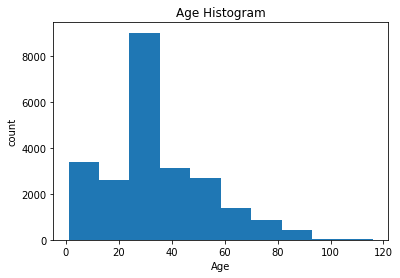

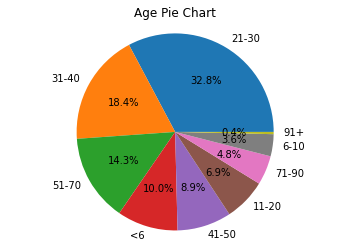

In [5]:
# plot histogram
hist_plot(dataframe)

# plot pie chart
bins = [0, 5, 10, 20, 30, 40, 50, 70, 90, np.inf]
labels = ['<6', '6-10', '11-20', '21-30', '31-40', '41-50', '51-70', '71-90', '91+']
age_binned = pd.cut(dataframe['age'], bins, labels=labels)
pie_plot(age_binned, "Age")

## Age Distribution
The following distribution shows the distribution of gender.

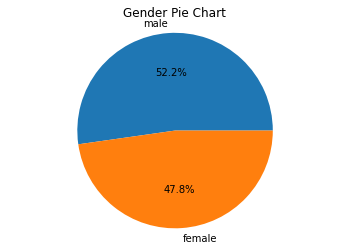

In [6]:
pie_plot(dataframe['gender'], "Gender")

## Race Distribution
The following distribution shows the distribution of all 5 races (white, black, asian, indian, and others).

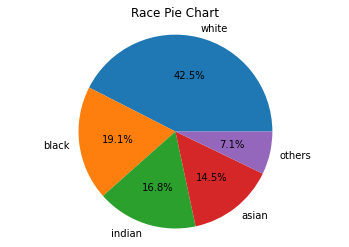

In [7]:
pie_plot(dataframe['race'], "Race")

## Dataset Separator
Splits the dataset into train, validation, and test splits.

In [8]:
class DatasetSeparator():
    def __init__(self, dataframe, train_size=5000, test_size=1000):
        self.dataframe = dataframe.sample(frac=1) # shuffles dataset
        self.maximum_age = dataframe['age'].max()
        self.train_size = train_size
        self.test_size = test_size
        self.progress_percent = 0.1

    def normalize_age(self, age):
        return (age / self.maximum_age)

    def normalize_image(self, image):
        return (np.array(image).flatten() / 255.0)

    def get_image(self, filename):
        return Image.open(filename)

    def get_race_value(self, race):
        return (dataset_label_ids['race_id'][race])

    def get_gender_value(self, gender):
        return (dataset_label_ids['gender_id'][gender])

    def preprocess_dataset(self, dataframe):
        # select subset of data
        dataframe = dataframe[:self.train_size + self.test_size]
        images = []
        # for printing progress
        progress_step = len(dataframe.index) * self.progress_percent
        # go through rows in dataframe
        for index, (row_index, image) in enumerate(dataframe.iterrows()):
            # normalize / update characteristics
            image['age'] = self.normalize_age(image['age'])
            image['race'] = self.get_race_value(image['race'])
            image['gender'] = self.get_gender_value(image['gender'])
            # normalize / update image data
            im = self.get_image(image['filename'])
            images.append(self.normalize_image(im))
            # show progress
            if (index % progress_step) == 0:
                print(f'~ Done {(index / len(dataframe.index)) * 100}%')
        # add images to dataframe
        images = np.array(images)
        # return modified dataset
        return images, dataframe

    def separate_dataset(self, images, dataframe):
        return train_test_split(
            images,
            dataframe[['age', 'race', 'gender', 'filename']],
            train_size=self.train_size,
            test_size=self.test_size
        )

    def get_dataset(self):
        images, dataframe = self.preprocess_dataset(self.dataframe)
        return self.separate_dataset(images, dataframe)

# separate dataset
dataset_separator = DatasetSeparator(dataframe)
x_train, x_test, y_train, y_test = dataset_separator.get_dataset()

~ Done 0.0%
~ Done 10.0%
~ Done 20.0%
~ Done 30.0%
~ Done 40.0%
~ Done 50.0%
~ Done 60.0%
~ Done 70.0%
~ Done 80.0%
~ Done 90.0%


## Build Keras Model
This builds what is essentially three separate neural network models.

The three separate models are shown below:

* 1\. Age Network
* 2\. Gender Network
* 3\. Race Network

Each model begins with a default set of layers, and is followed by a custom MobileNetV2 architecture each with separate activation functions.

In [23]:
class UtkMultiOutputModel():
    def __init__(self, epochs=100):
        self.epochs = epochs
        self.model = self.get_model(5)

    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        return x

    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)
        return x

    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)
        return x

    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)
        return x

    def get_model(self, num_races):
        inputs = Input(shape=(200, 200, 3))
        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)
        model = Model(
            inputs=inputs,
            outputs = [age_branch, race_branch, gender_branch],
            name="face_net"
        )
        return model

    def compile(self, optimizer, metrics, loss, loss_weights):
        self.model.compile(optimizer=optimizer, metrics=metrics, loss=loss, loss_weights=loss_weights)

    def train(self, train, test=None, batch_size=64, callbacks=None):
        return self.model.fit(
            train,
            validation_data=test,
            epochs=self.epochs,
            batch_size=batch_size,
            callbacks=callbacks,
        )

    def test(self, test, batch_size=64):
        return model.predict(test, batch_size=batch_size)

## Compile Model

In [24]:
# model parameters
optimizer = tf.keras.optimizers.Adam(lr=0.0004)
loss = {
    'age': 'mse',
    'gender': 'binary_crossentropy',
    'race': 'categorical_crossentropy'
}
loss_weights = {
    'age': 4., 
    'gender': 0.1,
    'race': 1.5
}
metrics = {
    'age': 'mae', 
    'gender': 'accuracy',
    'race': 'accuracy'
}

# instantiate and compile model
model = UtkMultiOutputModel()
model.compile(optimizer=optimizer, 
              loss=loss,
              loss_weights=loss_weights,
              metrics=metrics)

In [26]:
# setup callbacks (for saving model)
callbacks = [ModelCheckpoint("./classifier_checkpoint", monitor='val_loss')]

# 10 fold cross-validation
k_folds = KFold(n_splits=10)
for train_index, test_index in k_folds.split(x_train):
    # get current fold
    print('Fold Done')
    train_x, test_x = np.array(x_train)[train_index], np.array(x_train)[test_index]
    train_y, test_y = np.array(y_train)[train_index], np.array(y_train)[test_index]
    # train model
    model.train((train_x, test_x), (train_y, test_y), callbacks=callbacks)

Fold Done


ValueError: Data cardinality is ambiguous:
  x sizes: 4500, 500
Make sure all arrays contain the same number of samples.